Mostly about this paper:
###### https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1528077

this paper demonstrates how emotions with high arousal levels (anger, excitement) are shared more in social media. I wonder then, if we can prove the same for a population through word of mouth?

We can look at how different emotions spread in a population, for example given a rumour of particular high arousal, specifically one that causes anger in people, how fast does it spread in a population f 100000 habitants? 

what if it's a sad rumour? how fast will it spread?

    

In [1]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import random
import random
import pandas as pd
import networkx as nx
import random
import community as community_louvain 
from pyvis.network import Network
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer
from pyvis.network import Network

In [2]:
def calculate_emotion_impact(emotions, rumour_spreadability):
    """
    Calculates the impact of the emotions.
    """
    
    emotion_impact = 0

    for emotion in emotions:
        #default value 0 if i pass a non-existing emotion
        spreadability_value = rumour_spreadability.get(emotion, 0) 
        emotion_impact += spreadability_value
    
    return emotion_impact

#negative spreadability for sadness
rumourSpreadability = {
    "neutral": 0,
    "anger": 0.34,
    "anxiety": 0.21,
    "sadness": -0.16,
    "awe": 0.30,
    "interest": 0.25,
    "surprise": 0.14,
    "positivity": 0.13
}


# Now we create our Agent class

In [3]:
#rumorAgent class
class RumorAgent(Agent):
    """An agent with a rumor spreading behavior."""

    def __init__(self, unique_id, model, emotions=["neutral"]):
        super().__init__(unique_id, model)
        self.emotions = emotions  # initialize with a list of emotions
        self.informed = False

    def step(self):
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

        #changes emotions based on spread probability
        neighbors = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)
        for neighbor in neighbors:
            if "neutral" not in neighbor.emotions:
                spread_probability = self.calculate_emotion_impact(neighbor.emotions, self.model.rumour_spreadability_dict)
                if random.random() < spread_probability:
                    self.emotions = neighbor.emotions
                    break  #stop emotion change

    def calculate_emotion_impact(self, emotions, rumour_spreadability_dict):
        """
        Calculates the impact of the emotions based on the rumour spreadability values.
        """
        emotion_impact = 0
        for emotion in emotions:
            spreadability_value = rumour_spreadability_dict.get(emotion, 0)
            emotion_impact += spreadability_value
        return emotion_impact


# Now lets implement the model

In [4]:
#rumorModel class
class RumorModel(Model):
    """The Model class that places the agents in the grid, initiates them and makes the step."""

    def __init__(self, width, height, num_agents):
        self.num_agents = num_agents
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self._steps = 0  
        self._time = 0   

        self.rumour_spreadability_dict = {
            "neutral": 0,
            "anger": 0.34,
            "anxiety": 0.21,
            "sadness": -0.16,
            "awe": 0.30,
            "interest": 0.25,
            "surprise": 0.14,
            "positivity": 0.13
        }

        #creates agents
        for i in range(self.num_agents):
            a = RumorAgent(i, self)
            self.schedule.add(a)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        #initial rumour emotion to one random agent
        random_agent = self.random.choice(self.schedule.agents)
        random_agent.emotions = [rumour_emotion]

        self.datacollector = DataCollector(
            agent_reporters={"Emotions": "emotions"}  #collect the 'emotions' attribute
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        self._time += 1  

## Running the model 

In [5]:
#parameters defined at the beginning
rumour_spreadability = 0.5
rumour_emotion = "anger"
emotions_list = ["neutral", "anger", "anxiety", "sadness", "interest", "surprise", "positivity"]
movement_random = False
grid_x = 20
grid_y = 20
num_agents = 100
num_steps = 20

model = RumorModel(grid_x, grid_y, num_agents)
for i in range(num_steps):
    model.step()

#data collector
agent_data = model.datacollector.get_agent_vars_dataframe()

#debugging step: Print the head of the DataFrame to verify the columns
print(agent_data)

               Emotions
Step AgentID           
0    0        [neutral]
     1        [neutral]
     2        [neutral]
     3        [neutral]
     4        [neutral]
...                 ...
19   9          [anger]
     52       [neutral]
     83       [neutral]
     70       [neutral]
     65       [neutral]

[2000 rows x 1 columns]


C:\Users\Vasco\anaconda3\Lib\site-packages\mesa\time.py:82: FutureWarning: The AgentSet is experimental. It may be changed or removed in any and all future releases, including patch releases.
We would love to hear what you think about this new feature. If you have any thoughts, share them with us here: https://github.com/projectmesa/mesa/discussions/1919
  self._agents: AgentSet = AgentSet(agents, model)
C:\Users\Vasco\AppData\Local\Temp\ipykernel_5224\110163087.py:6: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


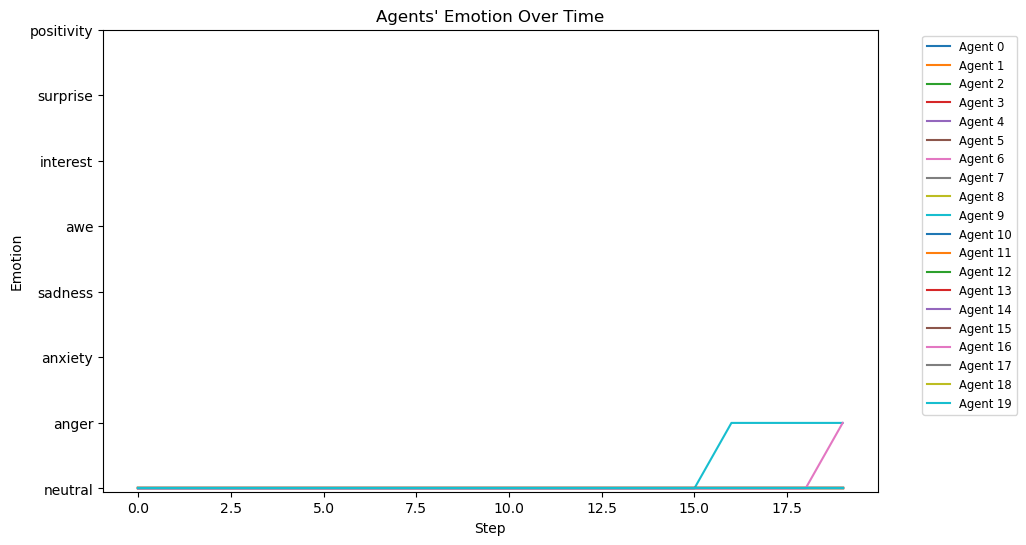

In [6]:
emotion_mapping = {"neutral": 0, "anger": 1, "anxiety": 2, "sadness": 3, "awe": 4, "interest": 5, "surprise": 6, "positivity": 7}


#convert the list of emotions to numerical values for plotting
def convert_emotions_to_num(emotion_list):
    return [emotion_mapping[e] for e in emotion_list]

if 'Emotions' in agent_data.columns:
    agent_data_exploded = agent_data.explode('Emotions')
    agent_data_exploded['EmotionNum'] = agent_data_exploded['Emotions'].map(lambda x: emotion_mapping[x])

    #plot the data for each agent
    plt.figure(figsize=(10, 6))
    for agent_id in agent_data_exploded.index.get_level_values(0).unique():
        agent_emotion = agent_data_exploded.xs(agent_id, level="AgentID")["EmotionNum"]
        plt.plot(agent_emotion, label=f'Agent {agent_id}')

    #y-axis to show the emotion names
    plt.yticks(list(emotion_mapping.values()), list(emotion_mapping.keys()))

    plt.xlabel("Step")
    plt.ylabel("Emotion")
    plt.title("Agents' Emotion Over Time")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.show()
else:
    print("The 'Emotions' column was not found in the collected data.")

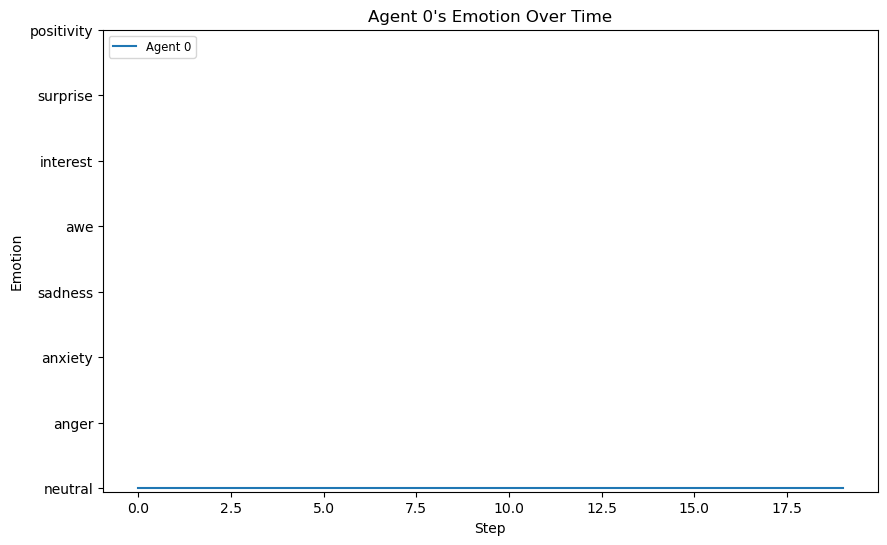

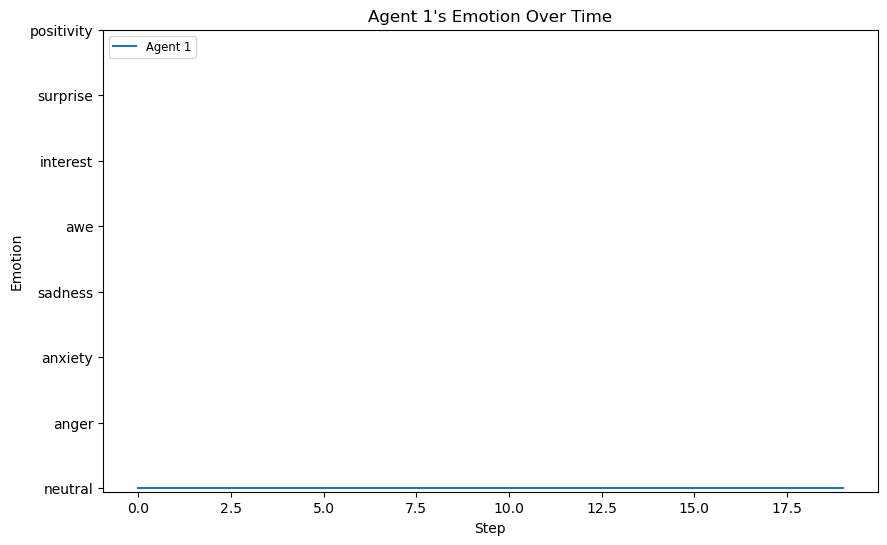

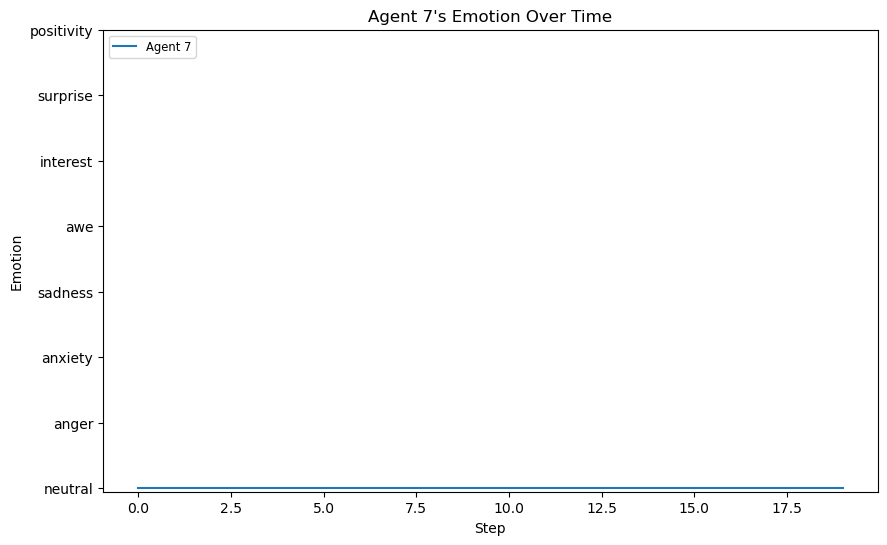

In [7]:
#plot emotion data for a specific agent
def plot_agent_emotion(agent_data, agent_id):
    if 'Emotions' in agent_data.columns:
        agent_emotion_data = agent_data.xs(agent_id, level="AgentID")
        agent_emotion_data_exploded = agent_emotion_data.explode('Emotions')
        agent_emotion_data_exploded['EmotionNum'] = agent_emotion_data_exploded['Emotions'].map(lambda x: emotion_mapping[x])

        plt.figure(figsize=(10, 6))
        plt.plot(agent_emotion_data_exploded.index.get_level_values(0), agent_emotion_data_exploded['EmotionNum'], label=f'Agent {agent_id}')

        plt.yticks(list(emotion_mapping.values()), list(emotion_mapping.keys()))

        plt.xlabel("Step")
        plt.ylabel("Emotion")
        plt.title(f"Agent {agent_id}'s Emotion Over Time")
        plt.legend(loc='upper left', fontsize='small')
        plt.show()
    else:
        print("The 'Emotions' column was not found in the collected data.")

        
#plot data for specific agents
plot_agent_emotion(agent_data, 0)
plot_agent_emotion(agent_data, 1)
plot_agent_emotion(agent_data, 7)

## Lets visualize a scatter plot to see how many agents have each emotion. usefull to see how many agents stayed at neutral 

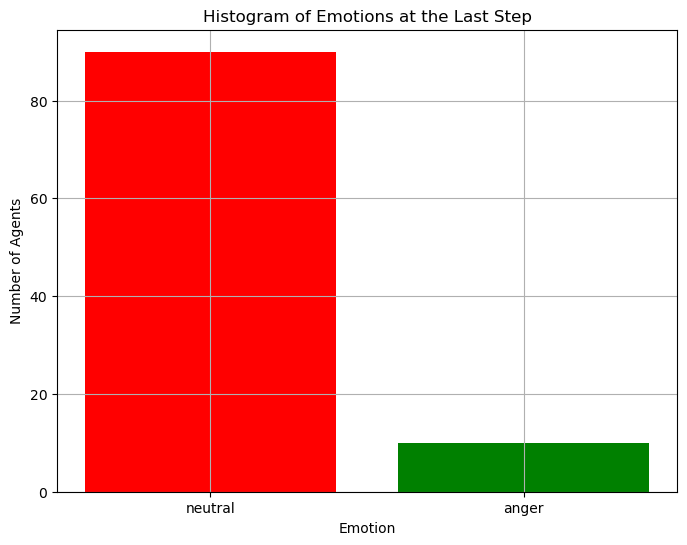

In [8]:
#count the emotions and their occurrences to make the histogram easier
last_step_data = agent_data.tail(num_agents).explode('Emotions')
emotion_counts = last_step_data['Emotions'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(emotion_counts.index, emotion_counts.values, color=['red', 'green'])

plt.xlabel('Emotion')
plt.ylabel('Number of Agents')
plt.title('Histogram of Emotions at the Last Step')
plt.grid()
plt.show()



In [9]:
neutral_count = (last_step_data['Emotions'] == 'neutral').sum()

#percentage of agents who don't know the rumor
percentage = (neutral_count / num_agents) * 100
print(f"Percentage of people (in the population of {num_agents}) who don't know the rumor: {percentage:.2f}%. This corresponds to a total of {neutral_count} people who don't know the rumor.")

Percentage of people (in the population of 100) who don't know the rumor: 90.00%. This corresponds to a total of 90 people who don't know the rumor.


# INTERACTIVE COOL THINGS --> The modelling is at an acceptable stage now! we start with an emotion and over time all the agents convert to that emotion

In [10]:
def agent_portrayal(agent):
    colors = {
        "neutral": "grey",
        "anger": "red",
        "anxiety": "blue",
        "sadness": "purple",
        "awe": "yellow",
        "interest": "green",
        "surprise": "orange",
        "positivity": "pink"
    }

    if agent.emotions:
        color = colors.get(agent.emotions[0], "grey")
    else:
        color = "grey"

    portrayal = {
        "Shape": "rect",
        "Color": color,
        "Filled": "true",
        "Layer": 0,
        "w": 1,
        "h": 1
    }
    return portrayal

#create a grid to visualize agents
grid = CanvasGrid(agent_portrayal, grid_x, grid_y, 500, 500)

def launch_server():
   
    model = RumorModel(grid_x, grid_y, num_agents)
    model.datacollector = DataCollector(
        agent_reporters={"Emotions": "emotions"}
    )

    server = ModularServer(
        RumorModel,  
        [grid],
        "Rumor Spread Model",
        {"width": grid_x, "height": grid_y, "num_agents": num_agents}
    )

    server.port = 8530 
    server.launch()

launch_server()

Interface starting at http://127.0.0.1:8530


C:\Users\Vasco\AppData\Local\Temp\ipykernel_5224\110163087.py:6: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


RuntimeError: This event loop is already running

# NETWORK NODE BASED MODELLING

In [11]:
rumour_spreadability = 0.7
rumour_emotion = "anger"
emotions_list = ["neutral", "anger", "anxiety", "sadness", "interest", "surprise", "positivity"]
movement_random = False


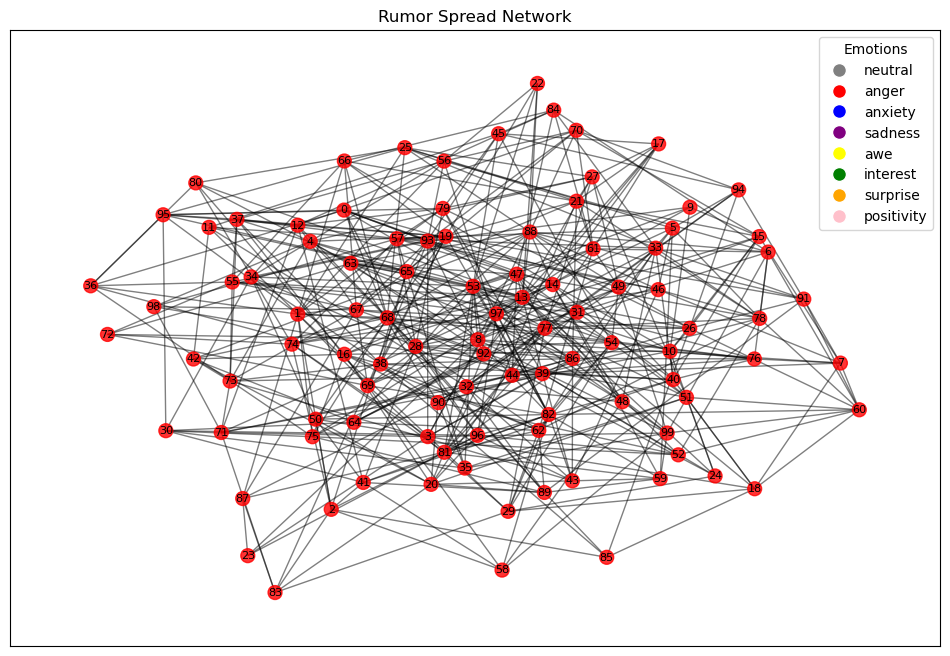

In [12]:
#initialize the network
G = nx.Graph()

num_agents = 100

for i in range(num_agents):
    G.add_node(i, emotion="neutral")

#random edges (connections) between nodes
for i in range(num_agents):
    for j in range(i + 1, num_agents):
        if random.random() < 0.1:  
            G.add_edge(i, j)

#function to calculate emotion impact
def calculate_emotion_impact(emotions, rumour_spreadability_dict):
    emotion_impact = 0
    for emotion in emotions:
        spreadability_value = rumour_spreadability_dict.get(emotion, 0)
        emotion_impact += spreadability_value
    return emotion_impact

def simulate_step(G, rumour_spreadability_dict):
    new_emotions = {}  # Temporary dictionary to store updates
    for node in G.nodes:
        neighbors = list(G.neighbors(node))
        for neighbor in neighbors:
            if G.nodes[neighbor]['emotion'] != "neutral":
                spread_probability = calculate_emotion_impact([G.nodes[neighbor]['emotion']], rumour_spreadability_dict)
                if random.random() < spread_probability:
                    new_emotions[node] = G.nodes[neighbor]['emotion']  # Store update
                    break
    for node, emotion in new_emotions.items():
        G.nodes[node]['emotion'] = emotion  

rumour_spreadability_dict = {
    "neutral": 0,
    "anger": 0.34,
    "anxiety": 0.21,
    "sadness": -0.16,
    "awe": 0.30,
    "interest": 0.25,
    "surprise": 0.14,
    "positivity": 0.13
}

#infect initial agent
random_agent = random.choice(list(G.nodes))
G.nodes[random_agent]['emotion'] = rumour_emotion

num_steps = 10
for step in range(num_steps):
    simulate_step(G, rumour_spreadability_dict)

#create a color map for the emotions
color_map = {"neutral": "grey", "anger": "red", "anxiety": "blue", "sadness": "purple",
             "awe": "yellow", "interest": "green", "surprise": "orange", "positivity": "pink"}

node_colors = [color_map[data['emotion']] for _, data in G.nodes(data=True)]

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42) 
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=100, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8, font_color="black")

#legend for the emotions
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[emotion], markersize=10, label=emotion)
                   for emotion in color_map]
plt.legend(handles=legend_elements, loc='upper right', title="Emotions")

plt.title("Rumor Spread Network")
plt.show()


In [13]:
G = nx.Graph()

num_agents = 100

for i in range(num_agents):
    G.add_node(i, emotion="neutral")

for i in range(num_agents):
    for j in range(i + 1, num_agents):
        if random.random() < 0.1: 
            G.add_edge(i, j)


def calculate_emotion_impact(emotions, rumour_spreadability):
    emotion_impact = 0
    for emotion in emotions:
        spreadability_value = rumour_spreadability.get(emotion, 0)
        emotion_impact += spreadability_value
    return emotion_impact

def simulate_step(G, rumour_spreadability):
    for node in G.nodes:
        neighbors = list(G.neighbors(node))
        for neighbor in neighbors:
            if G.nodes[neighbor]['emotion'] != "neutral":
                spread_probability = calculate_emotion_impact([G.nodes[neighbor]['emotion']], rumour_spreadability)
                if random.random() < spread_probability:
                    G.nodes[node]['emotion'] = G.nodes[neighbor]['emotion']
                    break

rumour_spreadability = {
    "neutral": 0,
    "anger": 0.34,
    "anxiety": 0.21,
    "sadness": -0.16,
    "awe": 0.30,
    "interest": 0.25,
    "surprise": 0.14,
    "positivity": 0.13
}


initial_rumour_emotion = "surprise"
random_agent = random.choice(list(G.nodes))
G.nodes[random_agent]['emotion'] = initial_rumour_emotion

num_steps = 10
for step in range(num_steps):
    simulate_step(G, rumour_spreadability)

net = Network(notebook=True, height="750px", width="100%", bgcolor="white", font_color="black")


emotion_colors = {
    "neutral": "grey",
    "anger": "red",
    "anxiety": "blue",
    "sadness": "purple",
    "awe": "yellow",
    "interest": "green",
    "surprise": "orange",
    "positivity": "pink"
}


for node, data in G.nodes(data=True):
    emotion = data['emotion']
    num_connections = len(list(G.neighbors(node)))
    label = f"{node}\n#con: {num_connections}"
    net.add_node(node, label=label, color=emotion_colors[emotion], title=f"Agent ID: {node}, Emotion: {emotion}")

for source, target in G.edges:
    net.add_edge(source, target)


net.set_options("""
var options = {
  "physics": {
    "enabled": true,
    "barnesHut": {
      "gravitationalConstant": -20000,
      "centralGravity": 0.3,
      "springLength": 100,
      "springConstant": 0.01,
      "damping": 0.09,
      "avoidOverlap": 1
    },
    "minVelocity": 0.75
  }
}
""")

legend_html = """
<div id="mynetworkLegend" style="position: absolute; top: 10px; right: 10px; background-color: white; padding: 10px; border: 1px solid black; z-index: 999;">
<h4>Legend</h4>
<h5>Emotions</h5>
<ul>
  <li style="color:grey;">Neutral</li>
  <li style="color:red;">Anger</li>
  <li style="color:blue;">Anxiety</li>
  <li style="color:purple;">Sadness</li>
  <li style="color:yellow;">Awe</li>
  <li style="color:green;">Interest</li>
  <li style="color:orange;">Surprise</li>
  <li style="color:pink;">Positivity</li>
</ul>
</div>
"""

net.html = net.html.replace('</body>', legend_html + '</body>')


net.show("rumor_spread.html")


rumor_spread.html
